# Solução Numérica da Equação de Laplace
***Mariana Jó (7241072)***

*Eletromagnetismo I, 2017*
___

Os seguintes passos serão seguidos a fim de encontrar a solução da Equação de Laplace 2D:

1. Definição da geometria
1. Discretização do domínio
1. Especificação das condições de contorno
1. "Chute" inicial de valores arbitrários para o interior da região
1. Aplicação os métodos que nos dão a solução

In [101]:
# Importando todas as bibliotecas necessárias na solução

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

## 1. Definição da geometria

Vamos analisar um problema de 2 dimensões, num retângulo de lados $m$ e $n$:

In [141]:
a, b = 100, 100

## 2. Discretização do domínio

Podemos escolher diversas formas de discretização $h$ e analisar os diferentes resultados para todas elas. Utilizaremos o sistema de coordenadas cartesianas, com o retângulo no plano $xy$, onde $0 \leq x \leq a$ e $0 \leq y \leq b$:

In [152]:
h = 100
x = np.linspace(0, a, h)
y = np.linspace(0, b, h)
xv, yv = np.meshgrid(x, y, sparse=True)

## 3. Especificação das condicões de contorno

Primeiramente definimos as condições de contorno nas bordas do retângulo:

1. $V(0,y)=75$
1. $V(a,y)=0$
1. $V(x,0)=50$
1. $V(x,b)=100$

In [153]:
bc = {"top":1000, 
      "bottom":50,
      "left":250,
      "right":0
     }

## 4. "Chute" inicial de valores arbitrários para o interior da região

Fazemos, então, com que os valores da região interna ao retângulo sejam a média dos valores nas bordas:

In [154]:
z = np.ones(shape=(h, h))*np.mean(list(bc.values()))

# Adicionando as condições de contorno nas bordas
z[0,1:-1] = bc["top"]
z[-1,1:-1] = bc["bottom"]
z[1:-1,0] = bc["left"]
z[1:-1,-1] = bc["right"]

Os valores das quinas sobrescrevem uns aos outros durante o procedimento anterior. Dessa maneira, fazemos com que as quinas sejam a média dos valores das bordas da quina em questão. Note que aqui há uma certa inconsistência física, pois nas quinas, fisicamente, ocorrem efeitos de borda. Porém, para este problema, vamos utilizar este procedimento da média.

In [155]:
z[0,0] = np.mean([bc["top"], bc["left"]])
z[0,-1] = np.mean([bc["top"], bc["right"]])
z[-1,0] = np.mean([bc["bottom"], bc["left"]])
z[-1,-1] = np.mean([bc["bottom"], bc["right"]])
print(z)

[[  625.  1000.  1000. ...,  1000.  1000.   500.]
 [  250.   325.   325. ...,   325.   325.     0.]
 [  250.   325.   325. ...,   325.   325.     0.]
 ..., 
 [  250.   325.   325. ...,   325.   325.     0.]
 [  250.   325.   325. ...,   325.   325.     0.]
 [  150.    50.    50. ...,    50.    50.    25.]]


Assim, temos nosso retângulo original, com os valores determinados nas bordas e estimados no interior:

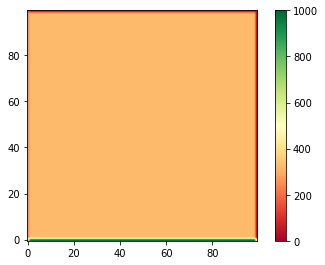

In [156]:
z_fig = plt.figure()
axes = z_fig.add_axes([0.1, 0.1, 0.8, 0.8])
mappable = axes.imshow(z, cmap=cm.RdYlGn, interpolation='gaussian', origin='lower')
z_fig.colorbar(mappable, ax=axes)

## 5. Aplicação os métodos que nos dão a solução

Iremos utilizar o mesmo número de iterações para cada método.

### Método de Jacobi

Para $N=10$:

In [157]:
N = 10

*Explicar o método sucintamente*

In [158]:
j = z

for i in range(N):
    for r, c in itertools.product(range(1, h-1), range(1, h-1)):
        adj = [z[r-1, c], z[r+1, c], z[r, c-1], z[r, c+1]]
        j[r, c] = np.mean(adj)

- Calculo do erro
- Gravar num dataframe

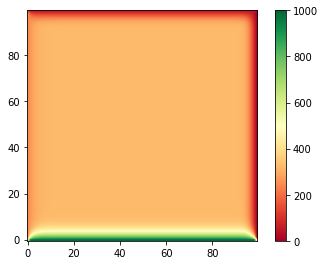

In [159]:
j_fig = plt.figure()
axes = j_fig.add_axes([0.1, 0.1, 0.8, 0.8])
mappable = axes.imshow(j, cmap=cm.RdYlGn, interpolation='gaussian', origin='lower')
j_fig.colorbar(mappable, ax=axes)

#### Análise de erro

### Método de Gauss-Seidel

Explicar método e a diferença dele pro Jacobi

Para $N=10$:

In [166]:
g = z                    

for i in range(N):
    for r, c in itertools.product(range(1, h-1), range(1, h-1)):
        adj = [g[r-1, c], g[r+1, c], g[r, c-1], g[r, c+1]]
        g[r, c] = np.mean(adj)
print(g)

[[  625.          1000.          1000.         ...,  1000.          1000.
    500.        ]
 [  250.           623.45930818   770.17403444 ...,   696.1829857
    499.26962586     0.        ]
 [  250.           473.71118033   618.93256192 ...,   497.09902882
    300.90563341     0.        ]
 ..., 
 [  250.           191.28818302   153.49290561 ...,    30.56407213
     17.89983712     0.        ]
 [  250.           150.88002992   112.21831902 ...,    37.66430703
     26.39103604     0.        ]
 [  150.            50.            50.         ...,    50.            50.
     25.        ]]


- Calculo do erro
- Gravar num dataframe

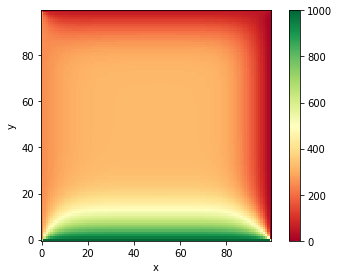

In [168]:
g_fig = plt.figure()
axes = g_fig.add_axes([0.1, 0.1, 0.8, 0.8])
mappable = axes.imshow(g, cmap=cm.RdYlGn, interpolation='none', origin='lower')
g_fig.colorbar(mappable, ax=axes)
plt.xlabel('x')
plt.ylabel('y')

#### Análise do erro